In [75]:
import h5py
import numpy as np

from tensorflow.keras import utils
from matplotlib import pyplot as plt
from PIL import Image
import pickle as pickle
from astropy.io import fits
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, concatenate

# Load images and coordinates for the images

In [4]:
zoo_coords = pd.read_csv('/Users/adamboesky/Desktop/General/College/CS109/Classifying_Galaxies/galaxy_coords.csv')

In [ ]:
import h5py
import numpy as np
from tensorflow.keras import utils


# To get the images and labels from file

with h5py.File('/Users/caleb/Downloads/Galaxy10_DECals.h5', 'r') as F:

    images = np.array(F['images'])

    labels = np.array(F['ans'])
    ras = np.array(F['ra'])
    decs = np.array(F['dec'])

In [74]:
from astroNN.models import Galaxy10CNN
from astroNN.datasets import galaxy10, load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = galaxy10.load_data()

KeyboardInterrupt: 

In [20]:
images, labels = load_galaxy10()

File corruption detected, astroNN is attempting to download again


Galaxy10_DECals.h5:  22%|██▏       | 603M/2.74G [02:28<08:47, 4.05MB/s]    


KeyboardInterrupt: 

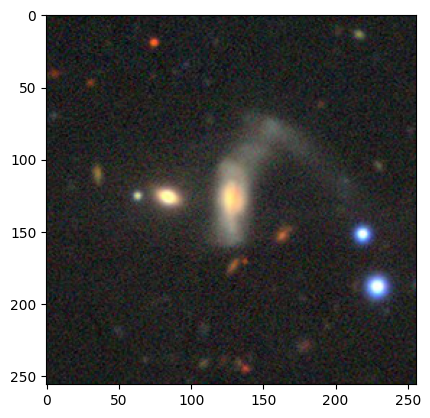

In [61]:
img = plt.imshow(images[0])

# Load the galaxy characteristics along with the coords

In [5]:
char_data = fits.open('/Volumes/T7/CS109/photoz.fits')

In [6]:
char_data[0].header

SIMPLE  =                    T / Standard FITS format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    1 / Text string                                    
NAXIS1  =                 3747 / Number of characters                           
VOTMETA =                    T / Table metadata in VOTable format               
EXTEND  =                    T / There are standard extensions                  
COMMENT                                                                         
COMMENT The data in this primary HDU consists of bytes which                    
COMMENT comprise a VOTABLE document.                                            
COMMENT The VOTable describes the metadata of the table contained               
COMMENT in the following BINTABLE extension.                                    
COMMENT Such a BINTABLE extension can be used on its own as a perfectly         
COMMENT good table, but the 

In [7]:
char_data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  256 / width of table in bytes                        
NAXIS2  =            303379640 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   61 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'ID      '           / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'RA      '           / label for column 2                             
TFORM2  = 'D       '        

In [8]:
prop_ra = char_data[1].data['RA']
prop_dec = char_data[1].data['DEC']
print(f'Obtained RA and DEC values for {len(prop_ra)} galaxies')

Obtained RA and DEC values for 303379640 galaxies


In [9]:
from multiprocess import Pool, cpu_count


# Where the zoo data is
min_dec = 0
max_dec = 60

# Functions for parallel processing
def get_mask(data_chunk):
    """Function to apply mask on a chunk of data."""
    print('Getting mask for chunk')
    mask = (data_chunk >= min_dec) & (data_chunk <= max_dec)
    return mask

def parallel_mask(data, chunks):
    """Function to apply mask in parallel."""
    with Pool(processes=cpu_count() - 2) as pool:
        print(f'Using {cpu_count() - 2} cores')
        result = pool.map(get_mask, np.array_split(data, chunks - 2))
    return np.concatenate(result)

In [10]:
if __name__ == '__main__':
    region_mask = parallel_mask(prop_dec, chunks=cpu_count())

Using 10 cores
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk
Getting mask for chunk


In [39]:
print(char_data[1].data['SFR_BEST'].shape)

(303379640,)


In [37]:
prop_dec[13500]

0.2991090584687351

In [35]:
prop_dec.shape

(303379640,)

In [20]:
prop_dec[-200:]

array([34.07254668, 34.07325945, 34.07301176, 34.07285841, 34.07497984,
       34.07438895, 34.07574944, 34.07405815, 34.0754487 , 34.07428465,
       34.07769715, 34.07922286, 34.07407751, 34.07393458, 34.07438319,
       34.07486939, 34.07613097, 34.0752859 , 34.0756195 , 34.07569888,
       34.07718979, 34.08139766, 34.07792256, 34.07797657, 34.07786333,
       34.07830713, 34.07864734, 34.08076109, 34.07990558, 34.07945581,
       34.08164831, 34.08073257, 34.08107308, 34.08103889, 34.08223853,
       34.08284458, 34.08149766, 34.08129443, 34.08224408, 34.08177306,
       34.08359167, 34.08207151, 34.08386024, 34.08521745, 34.08240172,
       34.08232303, 34.08311589, 34.0833085 , 34.11061284, 34.11407935,
       34.09359461, 34.08500866, 34.08567574, 34.08550128, 34.08522752,
       34.08506021, 34.08540801, 34.08554927, 34.08585678, 34.08840952,
       34.08723296, 34.087224  , 34.08716348, 34.0872639 , 34.08739343,
       34.08918855, 34.0875042 , 34.08742046, 34.08783062, 34.08

In [13]:
# Functions for parallel processing
def apply_mask(data_chunk_and_mask):
    """Function to apply mask on a chunk of data."""
    mask, ra_chunk, dec_chunk = data_chunk_and_mask
    print('Applying mask to chunk')
    return ra_chunk[mask], dec_chunk[mask]

def parallel_apply_mask(ra, dec, mask, chunks):
    """Function to apply mask in parallel."""
    with Pool(processes=cpu_count() - 2) as pool:
        print(f'Using {cpu_count() - 2} cores')
        result = pool.map(apply_mask, (np.array_split(mask, chunks - 2), np.array_split(ra, chunks - 2), np.array_split(dec, chunks - 2)))
    ra_masked, dec_masked = zip(*result)
    return np.concatenate(ra_masked), np.concatenate(dec_masked)


In [14]:
prop_ra_masked, prop_dec_masked = parallel_apply_mask(prop_ra, prop_dec, region_mask, chunks=cpu_count())

Using 10 cores


ValueError: too many values to unpack (expected 3)

In [ ]:
print(f'Filtered down to {len(char_data)}')

# Match the images with properties using cone sort

In [ ]:
prop_dec[1300000]

37.48051188353072

64.824245464805

In [61]:
zoo_coords['ra'].values

array([331.66405522, 334.53657795, 341.90248993, ..., 189.6026001 ,
       170.50016785, 133.54676819])

In [62]:
test_dec = prop_dec[1000000:1300000]
test_ra = prop_ra[1000000:1300000]

# Make SkyCoord object lists
zoo_sky_coords = SkyCoord(zoo_coords['ra'].values * u.deg, zoo_coords['dec'].values * u.deg, frame='icrs')
prop_sky_coords = SkyCoord(test_ra * u.deg, test_dec * u.deg, frame='icrs')

In [ ]:
# Make SkyCoord object lists
zoo_sky_coords = SkyCoord(zoo_coords['ra'] * u.deg, zoo_coords['dec'] * u.deg, frame='icrs')
prop_sky_coords = SkyCoord(char_data['RA'] * u.deg, char_data['DEC'] * u.deg, frame='icrs')

In [66]:
zoo_prop_match_inds = []
for zoo_i, coord in enumerate(zoo_sky_coords):
    if zoo_i % 1000 == 0:
        print(zoo_i)
    gal_seps = coord.separation(prop_sky_coords).arcsec
    smallest_sep = np.min(gal_seps)
    prop_j = np.argmin(gal_seps)
    if smallest_sep < 5:  # Host if the host is less than a 5 arcsec separation
        zoo_prop_match_inds.append((zoo_i, prop_j))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [67]:
zoo_prop_match_inds

[]

In [73]:
t = char_data[1].data['photo_z']
t

array([1.0254375 , 0.319007  , 0.9939402 , ..., 0.5564131 , 0.66731423,
       0.5332351 ], dtype=float32)